# Korg for GALAH O and Na abundances

This is a minimal working example of how one can fit abundances for GALAH spectra

This assumes the following simplifications:
- GALAH spectra are already normalised well (by the reduction pipeline)
- Stellar parameters are those of the Sun and we only have to optimise the rotational broadening (vsini)
- We use predefined windows for O and Na

In [1]:
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# Korg and Julia
from juliacall import Main as jl
jl.seval("using Korg")
Korg = jl.Korg

# general packages
import time
import numpy as np
from astropy.io import fits
from astropy.table import Table
from scipy.io import readsav

# matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
# sobject_id = 210115002201239
sobject_id = 140315001701356

In [3]:
# Reading in DR4 catalog. Note: for this example, I have limited the catalog to 1 row
galah_dr4 = Table.read('catalogs/galah_dr4_allstar_240207_vesta.fits')

find_sobject_id = np.where(galah_dr4['sobject_id'] == sobject_id)[0]
if len(find_sobject_id) != 1:
    if sobject_id == 140315001701356:
        find_sobject_id = 0
    else:
        raise ValueError('Did not find exactly 1 match for the given sobject_id!')
else:
    galah_dr4 = galah_dr4[find_sobject_id[0]]
    
if sobject_id == 140315001701356:
    galah_dr4['teff'] = 4400.
    galah_dr4['logg'] = 2.08
    galah_dr4['fe_h'] = -0.39
    galah_dr4['vmic'] = 1.59
    galah_dr4['vsini'] = 2.17
    galah_dr4['rv_comp_1'] = 30.

In [4]:
# Prepare Linelist
galah_lines = Korg.get_GALAH_DR3_linelist()

In [5]:
def rv_shift(rv_value, wavelength):
    """
    Shift the input wavelength array via a given radial velocity float
    """
    return(wavelength / (1.+rv_value/299792.458))

In [6]:
def get_spectrum(sobject_id, rv_value=None):
    """
    Retrieve the spectrum data for a given astronomical object identified by its sobject_id, applying
    a radial velocity (rv) shift if specified. The function reads spectrum data from FITS files located
    in a structured directory, applying the radial velocity correction to the wavelength values and 
    extracting relevant spectrum data across four Charge-Coupled Devices (CCDs).

    Parameters:
    - sobject_id (int): The unique identifier for the astronomical object. It dictates the path to the 
                        FITS files containing the spectrum data.
    - rv_value (float, optional): The radial velocity value to apply as a shift to the wavelength data. 
                                  If not provided, the RV value will be read from the RVCOM header of the 
                                  FITS file. Defaults to None.

    Returns:
    - dict: A dictionary containing the spectrum data for the object across four CCDs. Keys include
            'sobject_id', 'wave_air_ccdX', 'counts_ccdX', 'counts_unc_ccdX', 'flux_norm_ccdX', 
            and 'flux_unc_norm_ccdX' where X ranges from 1 to 4, representing each CCD.

    Raises:
    - FileNotFoundError: If the FITS files for the specified sobject_id cannot be found in the expected 
                         directory structure.
    - KeyError: If essential headers like 'RVCOM', 'CRVAL1', 'CDELT1', or 'NAXIS1' are missing in the 
                FITS file.

    Note:
    - This function assumes the directory structure follows the pattern 
      'observations/{sobject_id[:6]}/spectra/com/{sobject_id}{ccd}.fits' for accessing FITS files.
    - The function requires the `astropy.io.fits` module for reading FITS files and a custom `rv_shift` 
      function to apply the radial velocity correction to wavelength values.
    """
    
    spectrum = dict()
    spectrum['sobject_id'] = sobject_id
    
    for ccd in [1,2,3,4]:
        
        # Assuming that you use the same directory structure as GALAH_DR4/
        try:
            fits_file = fits.open('observations/'+str(sobject_id)[:6]+'/spectra/com/'+str(sobject_id)+str(ccd)+'.fits')
        except:
            raise FileNotFoundError('Could not find file '+'observations/'+str(sobject_id)[:6]+'/spectra/com/'+str(sobject_id)+str(ccd)+'.fits')

        if rv_value == None:
            rv_value = fits_file[0].header['RVCOM']

        # Read out wavelength from FITS header while also applying the radial velocity shift
        spectrum['wave_air_ccd'+str(ccd)] = rv_shift(
            rv_value, fits_file[0].header['CRVAL1'] + fits_file[0].header['CDELT1'] * np.arange(fits_file[0].header['NAXIS1'])
        )
        
        # Read out reduced (unnormalised) flux
        spectrum['counts_ccd'+str(ccd)] = fits_file[0].data
        spectrum['counts_unc_ccd'+str(ccd)] = fits_file[0].data * fits_file[2].data

        # Read out normalised flux (note: this is a reduction pipeline normalisation
        # and not the same as the DR4 analysis output.
        spectrum['flux_norm_ccd'+str(ccd)] = fits_file[1].data
        spectrum['flux_unc_norm_ccd'+str(ccd)] = fits_file[1].data * fits_file[2].data
        
        fits_file.close()

    return(spectrum)

spectrum = get_spectrum(sobject_id = sobject_id, rv_value=galah_dr4['rv_comp_1'])

# Concatenate the 4 CCDs into one
spectrum['wave_air'] = np.concatenate(([spectrum['wave_air_ccd'+str(ccd)] for ccd in [1,2,3,4]]))
spectrum['wave_vac'] = np.concatenate(([[Korg.air_to_vacuum(λ) for λ in spectrum['wave_air_ccd'+str(ccd)]] for ccd in [1,2,3,4]]))
spectrum['flux_norm'] = np.concatenate(([[f for f in spectrum['flux_norm_ccd'+str(ccd)]] for ccd in [1,2,3,4]]))
spectrum['flux_norm_unc'] = np.concatenate(([[f for f in spectrum['flux_unc_norm_ccd'+str(ccd)]] for ccd in [1,2,3,4]]))

In [8]:
# Prepare the line-spread function (LSF) to broaden the spectrum down to instrument resolution
synthesis_wls = jl.seval('4700:0.01:7900')
LSF_matrix = Korg.compute_LSF_matrix(
    synthesis_wls,
    spectrum['wave_vac'],
    28_000)

Constructing LSF matrix  27%|███████▋                    |  ETA: 0:00:42

# ELEMENT ABUNDANCES

In [11]:
# Define the windows for the elemental abundance fitting
# ToDo: Automate this!

windows = dict()

korg_extra_range = 0.5

# Li
windows[3] = [
    (Korg.air_to_vacuum(6707.300 - korg_extra_range),Korg.air_to_vacuum(6708.300 + korg_extra_range))
]

# C
windows[6] = [
    (Korg.air_to_vacuum(4716. - korg_extra_range),Korg.air_to_vacuum(4750. + korg_extra_range))
]

# O
windows[8] = [
    (Korg.air_to_vacuum(7771.359 - korg_extra_range),Korg.air_to_vacuum(7772.509 + korg_extra_range)),
    (Korg.air_to_vacuum(7773.522 - korg_extra_range),Korg.air_to_vacuum(7774.782 + korg_extra_range)),
    (Korg.air_to_vacuum(7774.912 - korg_extra_range),Korg.air_to_vacuum(7775.962 + korg_extra_range))
]

# Na
windows[11] = [
    (Korg.air_to_vacuum(4751.4 - korg_extra_range),Korg.air_to_vacuum(4752.2 + korg_extra_range)),
    (Korg.air_to_vacuum(5682.3 - korg_extra_range),Korg.air_to_vacuum(5683.3 + korg_extra_range)),
    (Korg.air_to_vacuum(5687.3 - korg_extra_range),Korg.air_to_vacuum(5688.7 + korg_extra_range))
]

# Mg
windows[12] = [
    (Korg.air_to_vacuum(4729.958 - korg_extra_range),Korg.air_to_vacuum(4730.302 + korg_extra_range)),
    (Korg.air_to_vacuum(5710.757 - korg_extra_range),Korg.air_to_vacuum(5711.428 + korg_extra_range)),
    (Korg.air_to_vacuum(7691.104 - korg_extra_range),Korg.air_to_vacuum(7691.879 + korg_extra_range))
]

# Al
windows[13] = [
    (Korg.air_to_vacuum(6695.778 - korg_extra_range),Korg.air_to_vacuum(6696.173 + korg_extra_range)),
    (Korg.air_to_vacuum(6698.392 - korg_extra_range),Korg.air_to_vacuum(6698.895 + korg_extra_range)),
    (Korg.air_to_vacuum(7834.884 - korg_extra_range),Korg.air_to_vacuum(7835.572 + korg_extra_range)),
    (Korg.air_to_vacuum(7835.813 - korg_extra_range),Korg.air_to_vacuum(7836.431 + korg_extra_range))
]

# Eu
windows[63] = [
    (Korg.air_to_vacuum(5818.400 - korg_extra_range),Korg.air_to_vacuum(5819.000 + korg_extra_range)),
    (Korg.air_to_vacuum(6644.820 - korg_extra_range),Korg.air_to_vacuum(6645.360 + korg_extra_range))
]

## Fit each element and save in fit_results dictionary

In [13]:
elements = ["Li", "O", "Na", "Mg", "Al", "Eu"]
elements = ["C"]

# Define the fixed parameters
fixed_parameters = dict(Teff = float(galah_dr4['teff']), logg = float(galah_dr4['logg']), m_H = float(galah_dr4['fe_h']), vmic = float(galah_dr4['vmic']), vsini = float(galah_dr4['vsini']))

# fixed_parameters = dict(Teff = 5772, logg = 4.44, m_H = 0.00, vmic = 1.06)

fit_results = dict()

for element in elements:
    
    print('Fitting '+element)

    # Define the initial fitting parameters
    initial_fitting_parameters = {element:0.0}

    # Feed into Korg's fitting function
    fit_results[element] = Korg.Fit.fit_spectrum(
        spectrum['wave_vac'],
        spectrum['flux_norm'],
        spectrum['flux_norm_unc'],
        galah_lines, 
        initial_fitting_parameters,
        fixed_parameters,
        windows=windows[Korg.atomic_numbers[element]],
        synthesis_wls=synthesis_wls, LSF_matrix=LSF_matrix
    )

    parameter_result = fit_results[element].best_fit_params
    params_sigma = np.sqrt(np.diag(fit_results[element].covariance[1]))

    print('Done Fitting '+element)
    print(str(spectrum['sobject_id'])+r' ['+element+'/H] = $'+"{:.3f}".format(parameter_result[element])+' \pm '+"{:.3f}".format(params_sigma[np.where(np.array(fit_results[element].covariance[0])==element)[0][0]])+'$'+r' ['+element+'/Fe] = $'+"{:.3f}".format(parameter_result[element] - fixed_parameters['m_H'])+' \pm '+"{:.3f}".format(params_sigma[np.where(np.array(fit_results[element].covariance[0])==element)[0][0]])+'$')

Fitting C
Done Fitting C
140315001701356 [C/H] = $-0.101 \pm 0.001$ [C/Fe] = $0.289 \pm 0.001$


/var/folders/g_/1ch053ys79n87jsnqjz0yr_h0000gq/T/ipykernel_27380/1630813284.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fixed_parameters = dict(Teff = float(galah_dr4['teff']), logg = float(galah_dr4['logg']), m_H = float(galah_dr4['fe_h']), vmic = float(galah_dr4['vmic']), vsini = float(galah_dr4['vsini']))


## Plot Results for each element

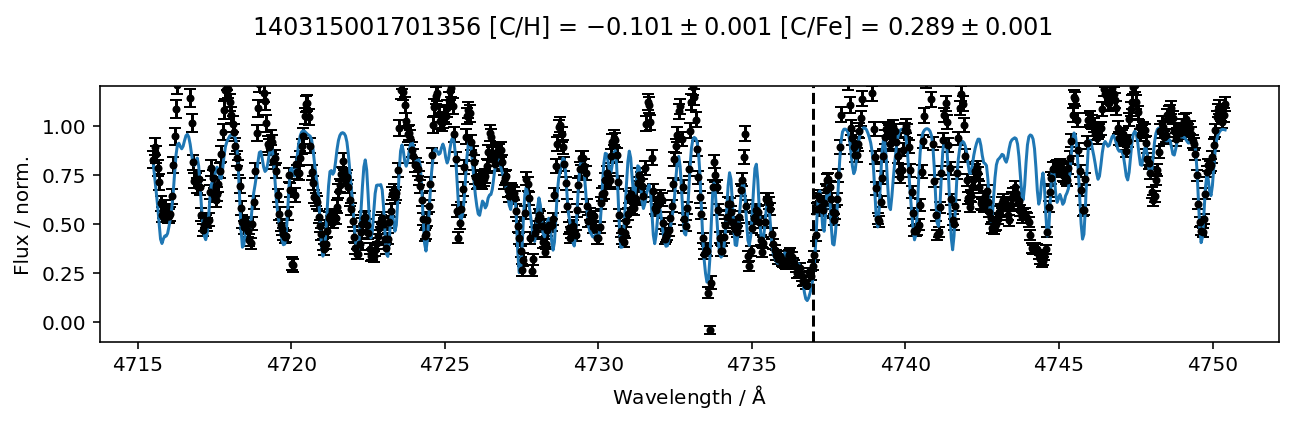

In [15]:
for element in elements:
    
    wavelength_type = 'wave_air'
    
    # Get pixels of observed and synthetic segments
    obs_wl_mask = np.array(fit_results[element].obs_wl_mask)
    mask_not_zero = np.where(obs_wl_mask[:-1] > 0)[0]
    mask_begin = np.where(mask_not_zero[1:] - mask_not_zero[:-1] != 1)[0]
    
    if len(mask_begin) > 0:
        obs_pixels = [[mask_not_zero[0],mask_not_zero[mask_begin[0]]]]
        syn_pixels = [[0,mask_begin[0]]]
        if len(mask_begin) > 1:
            for index in range(len(mask_begin)-1):
                obs_pixels.append([mask_not_zero[mask_begin[index]+1],mask_not_zero[mask_begin[index+1]]])
                syn_pixels.append([mask_begin[index]+1,mask_begin[index+1]])
            obs_pixels.append([mask_not_zero[mask_begin[index+1]+1],mask_not_zero[-1]])
            syn_pixels.append([mask_begin[index+1]+1,len(mask_not_zero)-1])        
        else:
            obs_pixels.append([mask_not_zero[mask_begin[0]+1],mask_not_zero[-1]])
            syn_pixels.append([mask_begin[0]+1,len(mask_not_zero)-1])        
    else:
        obs_pixels = [[mask_not_zero[0],mask_not_zero[-1]]]
        syn_pixels = [[0,len(mask_not_zero)-1]]

    # Plot Results
    f, gs = plt.subplots(1,len(obs_pixels),figsize=(9,3),sharey=True)
    for panel in range(len(obs_pixels)):

        if len(obs_pixels) > 1:
            ax = gs[panel]
        else:
            ax = gs
        ax.errorbar(
            spectrum[wavelength_type][obs_pixels[panel][0]:obs_pixels[panel][-1]],
            spectrum['flux_norm'][obs_pixels[panel][0]:obs_pixels[panel][-1]],
            yerr = spectrum['flux_norm_unc'][obs_pixels[panel][0]:obs_pixels[panel][-1]],
            fmt = '.', c = 'k', capsize = 3
        )
        
        ax.plot(
            spectrum[wavelength_type][obs_pixels[panel][0]:obs_pixels[panel][-1]],
            fit_results[element].best_fit_flux[syn_pixels[panel][0]:syn_pixels[panel][-1]]
        )
        
        # Show expected line centers as dashed lines
        if element == 'Li': lines = [6707.7635]
        if element == 'C' : lines = [4737.0]
        if element == 'O' : lines = [7771.9440,7774.1660,7775.3880]
        if element == 'Na': lines = [4751.8218,5682.6333,5688.2050]
        if element == 'Mg': lines = [4730.0286,5711.0880,7691.5500]
        if element == 'Al': lines = [6696.0230,6698.6730,7835.3090,7836.1340]
        if element == 'Eu': lines = [5818.7274,6645.0978]
        for line in lines:
            if wavelength_type == 'wave_vac':
                air_vac_line = Korg.air_to_vacuum(line)
            else:
                air_vac_line = line
            if (
                (air_vac_line > spectrum[wavelength_type][obs_pixels[panel][0]]) &
                (air_vac_line < spectrum[wavelength_type][obs_pixels[panel][-1]])
            ):
                ax.axvline(air_vac_line,c='k',ls='dashed')

        # Get results and uncertainties and add show them as title
        parameter_result = fit_results[element].best_fit_params
        params_sigma = np.sqrt(np.diag(fit_results[element].covariance[1]))
        if panel == 0:
            f.suptitle(str(spectrum['sobject_id'])+r' ['+element+'/H] = $'+"{:.3f}".format(parameter_result[element])+' \pm '+"{:.3f}".format(params_sigma[np.where(np.array(fit_results[element].covariance[0])==element)[0][0]])+'$'+r' ['+element+'/Fe] = $'+"{:.3f}".format(parameter_result[element] - fixed_parameters['m_H'])+' \pm '+"{:.3f}".format(params_sigma[np.where(np.array(fit_results[element].covariance[0])==element)[0][0]])+'$')
            ax.set_ylabel('Flux / norm.')
        ax.set_xlabel(r'Wavelength / $\mathrm{\AA}$')
        
    ax.set_ylim(-0.1,1.2)
    plt.tight_layout()
    plt.show()
    plt.close()